In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import shapely
from tqdm.autonotebook import tqdm
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import linregress
from sklearn.model_selection import KFold, RepeatedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

from src.processing import gedi_recovery_analysis
from src import constants


/tmp/ipykernel_2539069/1659163193.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Run recovery analysis spark pipeline

```
$ python src/spark/recovery_analysis_pipeline.py --survey_name=<eba_OR_paisagenslidar> --save_path=<DIR>
```

Paisagenslidar takes about one minute; EBA takes about 12 mins

In [7]:
als = pd.concat([
    pd.read_feather(constants.PAISAGENSLIDAR_PATH / 'paisagenslidar_recovery_analysis_extended_qf.feather'),
    pd.read_feather(constants.EBALIDAR_PATH / 'eba_recovery_analysis_extended_qf.feather')
])
als

,recovery_period,overlap_quality,chm_mean,chm_min,chm_max,chm_med,chm_mode,chm_q1,chm_q3,mean,max,quantile0.05,quantile0.1,interquartile_range,kurtosis,longo_biomass,n_pulses,n_points,n_ground_points,x_coord,y_coord,x_index,y_index,acd_longo2016,acd_asner2014,acd_asner2014c,survey,survey_year,crs
0,1,0,3.126884,0.000,13.280000,2.769,0.000,2.041,3.553,1.568604,13.470000,0.0,0.000,2.3800,10.349234,0.0,51645,54657,17918,723775.0,9656525.0,12,1,4.015971,20.278557,8.919645,TAP_A02_2016,2016,+init=epsg:32721
1,1,0,2.377340,0.000,12.376000,2.015,0.000,1.399,2.756,1.053907,12.510000,0.0,0.000,1.5000,21.680040,0.0,25170,26206,8704,723875.0,9656525.0,14,1,2.479217,15.621743,6.300946,TAP_A02_2016,2016,+init=epsg:32721
2,1,0,1.862138,0.098,12.965000,1.337,1.357,0.979,1.782,0.762237,13.080000,0.0,0.000,1.0400,35.870655,0.0,21013,21867,7727,723925.0,9656525.0,15,1,1.612927,12.380605,4.622488,TAP_A02_2016,2016,+init=epsg:32721
3,6,0,6.805651,0.058,13.966000,8.374,1.567,2.226,9.358,4.608120,14.030000,0.0,0.000,7.4300,1.690822,0.0,14019,18941,3933,723975.0,9656525.0,16,1,15.784992,42.518945,23.916191,TAP_A02_2016,2016,+init=epsg:32721
4,1,0,4.785214,0.000,24.200001,2.866,3.828,1.526,4.323,3.552818,24.330000,0.0,0.000,3.1300,6.349496,0.0,58840,66079,11634,723925.0,9656325.0,15,5,8.492200,30.405819,15.300220,TAP_A02_2016,2016,+init=epsg:32721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,6,1,8.305098,0.123,16.341999,8.087,7.559,6.949,9.200,6.977869,16.600000,0.0,2.778,3.0300,3.715261,0.0,5620,6719,372,785525.0,280475.0,28,15,22.409930,51.393331,30.786458,NP_T-0580,2016,+init=epsg:3180
37691,7,0,5.833845,0.000,11.938000,6.035,0.000,4.436,7.281,4.523551,12.140000,0.0,0.000,3.5400,2.462236,0.0,9518,11534,1899,785575.0,280475.0,29,15,12.035784,36.718052,19.671194,NP_T-0580,2016,+init=epsg:3180
37692,6,0,7.884999,0.000,15.637000,8.540,0.000,6.697,9.961,6.295036,15.760000,0.0,0.000,4.7700,2.400585,0.0,8286,10095,1397,785625.0,280475.0,30,15,20.453359,48.915413,28.825082,NP_T-0580,2016,+init=epsg:3180
37693,4,0,7.944738,0.000,19.582001,7.806,0.000,4.753,10.716,5.308165,19.809999,0.0,0.000,6.8925,2.835754,0.0,16696,20444,4782,785675.0,280475.0,31,15,20.726874,49.268158,29.102322,NP_T-0580,2016,+init=epsg:3180


In [3]:
quality_als = als[(als.overlap_quality >= 2) & (als.recovery_period >= 3) & (als.recovery_period <= 22)] 
len(quality_als)

1778

In [4]:
lin_chm_med = linregress(quality_als.recovery_period, quality_als.chm_med)
lin_acd_longo2016 = linregress(quality_als.recovery_period, quality_als.acd_longo2016)
lin_acd_asner2014 = linregress(quality_als.recovery_period, quality_als.acd_asner2014)

def fit_model(q, mod):
    res = mod.fit(q=q)
    return [
        q, 
        res.params["Intercept"],
        *res.conf_int().loc["Intercept"],
        res.params["recovery_period"],
        *res.conf_int().loc["recovery_period"],
        res.prsquared,
    ]

mod_longo2016 = smf.quantreg("acd_longo2016 ~ recovery_period", quality_als)
mod_asner2014 = smf.quantreg("acd_asner2014 ~ recovery_period", quality_als)

print(mod_longo2016.fit(q=0.5).summary())
print(mod_asner2014.fit(q=0.5).summary())
median_longo2016 = fit_model(0.5, mod_longo2016)
print(median_longo2016)
median_asner2014 = fit_model(0.5, mod_asner2014)


                         QuantReg Regression Results                          
Dep. Variable:          acd_longo2016   Pseudo R-squared:               0.1898
Model:                       QuantReg   Bandwidth:                       4.720
Method:                 Least Squares   Sparsity:                        27.38
Date:                Thu, 05 May 2022   No. Observations:                 1778
Time:                        16:45:14   Df Residuals:                     1776
                                        Df Model:                            1
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.1544      0.689     11.833      0.000       6.803       9.506
recovery_period     1.7950      0.062     29.158      0.000       1.674       1.916
                         QuantReg Regression Results                          
Dep. Variable:          acd_asne

Text(0.2, 25.2, 'R-score: 0.61\nslope: 0.38 m/yr\nintercept: 5.15 m')

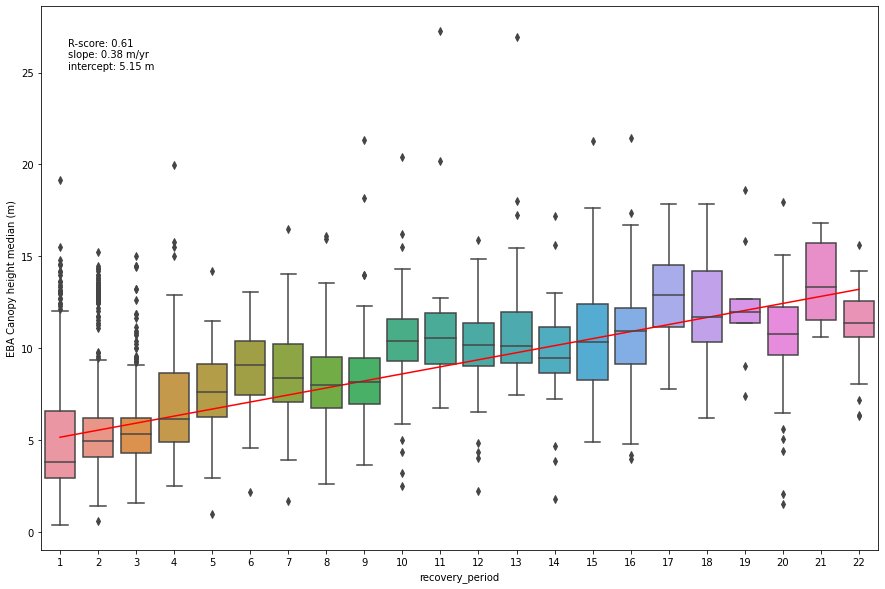

In [60]:
plt.figure(1, (15,10))
ax = sns.boxplot(x="recovery_period", y="chm_med", data=quality_als)
ax.set_ylabel("EBA Canopy height median (m)")
xs = range(0, 22)
ax.plot(xs, lin_chm_med.intercept + lin_chm_med.slope * xs, 'r')
text_label = (
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} m/yr\n"
    "intercept: {2:.2f} m").format(
        lin_chm_med.rvalue, lin_chm_med.slope, lin_chm_med.intercept)
ax.text(x=0.2, y=25.2, s=text_label)

Text(4.2, 148.67748778589527, 'Asner median (yellow):\nR-score: 0.19\nslope: 2.01 MgC/ha/yr\nintercept: 34.81 MgC/ha')

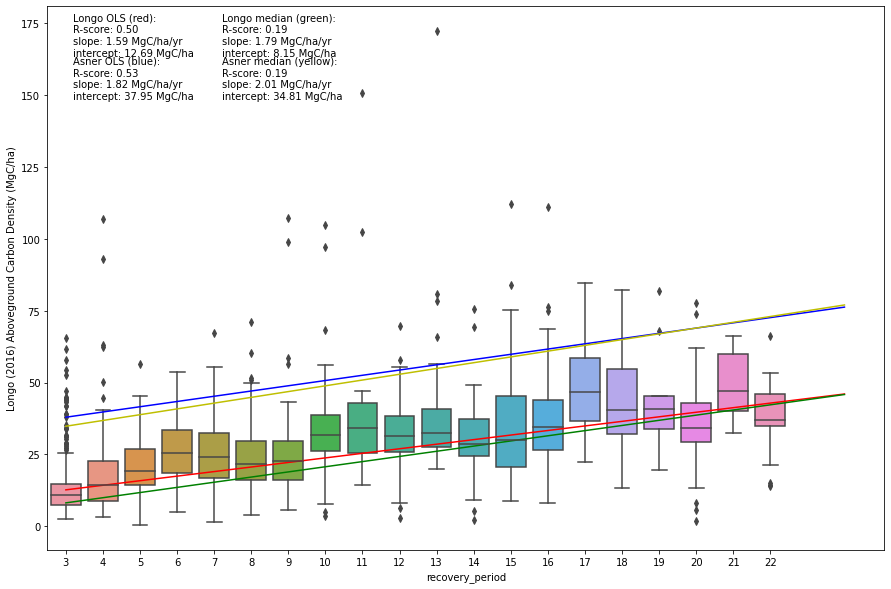

In [5]:
plt.figure(2, (15,10))
max = quality_als.acd_longo2016.max()
ax = sns.boxplot(x="recovery_period", y="acd_longo2016", data=quality_als)
ax.set_ylabel("Longo (2016) Aboveground Carbon Density (MgC/ha)")
xs = range(0, 22)
ax.plot(xs, lin_acd_longo2016.intercept + lin_acd_longo2016.slope * xs, 'r')
ax.plot(xs, lin_acd_asner2014.intercept + lin_acd_asner2014.slope * xs, 'b')
ax.plot(xs, median_longo2016[1] + median_longo2016[4] * xs, 'g')
ax.plot(xs, median_asner2014[1] + median_asner2014[4] * xs, 'y')
text_label = (
    'Longo OLS (red):\n'
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} MgC/ha").format(
        lin_acd_longo2016.rvalue, lin_acd_longo2016.slope, lin_acd_longo2016.intercept)
ax.text(x=0.2, y=max*0.95, s=text_label)
text_label = (
    'Asner OLS (blue):\n'
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} MgC/ha").format(
        lin_acd_asner2014.rvalue, lin_acd_asner2014.slope, lin_acd_asner2014.intercept)
ax.text(x=0.2, y=max*0.95 - 15, s=text_label)
text_label = (
    'Longo median (green):\n'
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} MgC/ha").format(
        median_longo2016[7], median_longo2016[4], median_longo2016[1])
ax.text(x=4.2, y=max*0.95, s=text_label)
text_label = (
    'Asner median (yellow):\n'
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} MgC/ha").format(
        median_asner2014[7], median_asner2014[4], median_asner2014[1])
ax.text(x=4.2, y=max*0.95 - 15, s=text_label)